In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_2048_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 2048)              1886208   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 1)                 129       


Total params: 4673537 (17.83 MB)


Trainable params: 4673537 (17.83 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:42 - loss: 0.0905 - STD: 4.2837e-05 - MAE: 0.2857

 3/74 [>.............................] - ETA: 2s - loss: 0.0382 - STD: 6.2400e-05 - MAE: 0.1527  

 5/74 [=>............................] - ETA: 2s - loss: 0.0312 - STD: 4.3683e-05 - MAE: 0.1362

 7/74 [=>............................] - ETA: 2s - loss: 0.0294 - STD: 3.2342e-05 - MAE: 0.1337

 9/74 [==>...........................] - ETA: 2s - loss: 0.0283 - STD: 2.5779e-05 - MAE: 0.1322

11/74 [===>..........................] - ETA: 1s - loss: 0.0273 - STD: 2.1850e-05 - MAE: 0.1296

13/74 [====>.........................] - ETA: 1s - loss: 0.0258 - STD: 1.9391e-05 - MAE: 0.1250

15/74 [=====>........................] - ETA: 1s - loss: 0.0241 - STD: 1.7577e-05 - MAE: 0.1194

17/74 [=====>........................] - ETA: 1s - loss: 0.0224 - STD: 1.6194e-05 - MAE: 0.1141

19/74 [======>.......................] - ETA: 1s - loss: 0.0211 - STD: 1.5003e-05 - MAE: 0.1108

21/74 [=======>......................] - ETA: 1s - loss: 0.0202 - STD: 1.4119e-05 - MAE: 0.1091

23/74 [========>.....................] - ETA: 1s - loss: 0.0195 - STD: 1.3183e-05 - MAE: 0.1078

25/74 [=========>....................] - ETA: 1s - loss: 0.0188 - STD: 1.2460e-05 - MAE: 0.1060

27/74 [=========>....................] - ETA: 1s - loss: 0.0181 - STD: 1.1781e-05 - MAE: 0.1039

29/74 [==========>...................] - ETA: 1s - loss: 0.0175 - STD: 1.1176e-05 - MAE: 0.1019

31/74 [===========>..................] - ETA: 1s - loss: 0.0170 - STD: 1.0677e-05 - MAE: 0.1001

33/74 [============>.................] - ETA: 1s - loss: 0.0166 - STD: 1.0276e-05 - MAE: 0.0985

35/74 [=============>................] - ETA: 1s - loss: 0.0162 - STD: 9.8289e-06 - MAE: 0.0972

37/74 [==============>...............] - ETA: 1s - loss: 0.0159 - STD: 9.4409e-06 - MAE: 0.0959

39/74 [==============>...............] - ETA: 1s - loss: 0.0155 - STD: 9.1236e-06 - MAE: 0.0948

41/74 [===============>..............] - ETA: 1s - loss: 0.0152 - STD: 8.8349e-06 - MAE: 0.0940

43/74 [================>.............] - ETA: 0s - loss: 0.0150 - STD: 8.5796e-06 - MAE: 0.0933

45/74 [=================>............] - ETA: 0s - loss: 0.0147 - STD: 8.3401e-06 - MAE: 0.0926

47/74 [==================>...........] - ETA: 0s - loss: 0.0145 - STD: 8.1541e-06 - MAE: 0.0920

49/74 [==================>...........] - ETA: 0s - loss: 0.0143 - STD: 7.9697e-06 - MAE: 0.0914

51/74 [===================>..........] - ETA: 0s - loss: 0.0141 - STD: 7.8102e-06 - MAE: 0.0907

53/74 [====================>.........] - ETA: 0s - loss: 0.0139 - STD: 7.6273e-06 - MAE: 0.0901

54/74 [====================>.........] - ETA: 0s - loss: 0.0139 - STD: 7.5529e-06 - MAE: 0.0898

56/74 [=====================>........] - ETA: 0s - loss: 0.0137 - STD: 7.3927e-06 - MAE: 0.0892

58/74 [======================>.......] - ETA: 0s - loss: 0.0135 - STD: 7.2496e-06 - MAE: 0.0887

60/74 [=======================>......] - ETA: 0s - loss: 0.0134 - STD: 7.1241e-06 - MAE: 0.0883

62/74 [========================>.....] - ETA: 0s - loss: 0.0133 - STD: 6.9959e-06 - MAE: 0.0879

64/74 [========================>.....] - ETA: 0s - loss: 0.0131 - STD: 6.9022e-06 - MAE: 0.0875

66/74 [=========================>....] - ETA: 0s - loss: 0.0130 - STD: 6.7895e-06 - MAE: 0.0872

68/74 [==========================>...] - ETA: 0s - loss: 0.0129 - STD: 6.6823e-06 - MAE: 0.0868

70/74 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 6.5846e-06 - MAE: 0.0865

72/74 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 6.4876e-06 - MAE: 0.0862

74/74 [==============================] - ETA: 0s - loss: 0.0126 - STD: 6.3936e-06 - MAE: 0.0859

74/74 [==============================] - 5s 50ms/step - loss: 0.0126 - STD: 6.3936e-06 - MAE: 0.0859 - val_loss: 0.0086 - val_STD: 3.1620e-06 - val_MAE: 0.0712


Epoch 2/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0090 - STD: 3.3311e-06 - MAE: 0.0740

 3/74 [>.............................] - ETA: 2s - loss: 0.0091 - STD: 3.6567e-06 - MAE: 0.0745

 5/74 [=>............................] - ETA: 2s - loss: 0.0093 - STD: 3.3737e-06 - MAE: 0.0753

 7/74 [=>............................] - ETA: 2s - loss: 0.0093 - STD: 3.3188e-06 - MAE: 0.0752

 9/74 [==>...........................] - ETA: 2s - loss: 0.0093 - STD: 3.6268e-06 - MAE: 0.0754

11/74 [===>..........................] - ETA: 2s - loss: 0.0093 - STD: 3.7661e-06 - MAE: 0.0757

13/74 [====>.........................] - ETA: 1s - loss: 0.0093 - STD: 3.9275e-06 - MAE: 0.0756

15/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 3.7585e-06 - MAE: 0.0755

17/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 3.6601e-06 - MAE: 0.0755

19/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 3.5905e-06 - MAE: 0.0754

21/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 3.5547e-06 - MAE: 0.0754

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 3.5863e-06 - MAE: 0.0753

25/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 3.5727e-06 - MAE: 0.0753

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 3.5207e-06 - MAE: 0.0754

29/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 3.5922e-06 - MAE: 0.0754

31/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 3.6586e-06 - MAE: 0.0754

33/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 3.6652e-06 - MAE: 0.0754

35/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 3.6558e-06 - MAE: 0.0754

37/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 3.6594e-06 - MAE: 0.0754

39/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 3.7471e-06 - MAE: 0.0754

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 3.8146e-06 - MAE: 0.0754

43/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 3.7769e-06 - MAE: 0.0754

45/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 3.8047e-06 - MAE: 0.0754

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 3.7825e-06 - MAE: 0.0754

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 3.7853e-06 - MAE: 0.0755

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 3.8091e-06 - MAE: 0.0755

54/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 3.8936e-06 - MAE: 0.0755

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 3.9619e-06 - MAE: 0.0755

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 3.9692e-06 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.9897e-06 - MAE: 0.0755

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 4.0034e-06 - MAE: 0.0755

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 4.0108e-06 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.9994e-06 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.9924e-06 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.9861e-06 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 3.9748e-06 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 3.9557e-06 - MAE: 0.0754

74/74 [==============================] - 3s 35ms/step - loss: 0.0092 - STD: 3.9557e-06 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 3.1300e-06 - val_MAE: 0.0716


Epoch 3/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0092 - STD: 3.3459e-06 - MAE: 0.0756

 3/74 [>.............................] - ETA: 2s - loss: 0.0092 - STD: 3.1867e-06 - MAE: 0.0755

 5/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 4.2209e-06 - MAE: 0.0753

 7/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 5.0349e-06 - MAE: 0.0752

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 5.3116e-06 - MAE: 0.0754

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 5.4308e-06 - MAE: 0.0754

13/74 [====>.........................] - ETA: 1s - loss: 0.0092 - STD: 5.5736e-06 - MAE: 0.0754

15/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 5.6516e-06 - MAE: 0.0754

17/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 5.7174e-06 - MAE: 0.0753

19/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 5.8313e-06 - MAE: 0.0753

21/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 6.0951e-06 - MAE: 0.0753

23/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 6.3242e-06 - MAE: 0.0753

25/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 6.4119e-06 - MAE: 0.0753

27/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 6.5421e-06 - MAE: 0.0754

29/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 6.5366e-06 - MAE: 0.0754

31/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 6.5648e-06 - MAE: 0.0754

33/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 6.5914e-06 - MAE: 0.0754

35/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 6.6048e-06 - MAE: 0.0754

37/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 6.9423e-06 - MAE: 0.0754

39/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 7.2527e-06 - MAE: 0.0754

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 7.4977e-06 - MAE: 0.0755

43/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 7.5848e-06 - MAE: 0.0755

45/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 7.6750e-06 - MAE: 0.0754

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 7.7796e-06 - MAE: 0.0754

49/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 7.9133e-06 - MAE: 0.0755

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 8.0145e-06 - MAE: 0.0754

54/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 8.1578e-06 - MAE: 0.0754

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 8.3103e-06 - MAE: 0.0755

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 8.4131e-06 - MAE: 0.0755

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 8.5449e-06 - MAE: 0.0755

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 8.7274e-06 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 8.8636e-06 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 9.0397e-06 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 9.2414e-06 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 9.3656e-06 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 9.4765e-06 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 9.5629e-06 - MAE: 0.0754

74/74 [==============================] - 3s 35ms/step - loss: 0.0092 - STD: 9.5629e-06 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.0120e-05 - val_MAE: 0.0718


Epoch 4/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0093 - STD: 1.5037e-05 - MAE: 0.0756

 3/74 [>.............................] - ETA: 2s - loss: 0.0092 - STD: 1.6247e-05 - MAE: 0.0757

 5/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 1.5069e-05 - MAE: 0.0755

 7/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 1.5920e-05 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 1.5865e-05 - MAE: 0.0753

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 1.6115e-05 - MAE: 0.0753

13/74 [====>.........................] - ETA: 1s - loss: 0.0092 - STD: 1.6375e-05 - MAE: 0.0752

15/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 1.6696e-05 - MAE: 0.0752

17/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 1.6915e-05 - MAE: 0.0753

19/74 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 1.7556e-05 - MAE: 0.0752

21/74 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 1.7895e-05 - MAE: 0.0752

24/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 1.8537e-05 - MAE: 0.0752

26/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 1.8989e-05 - MAE: 0.0752

28/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 1.9352e-05 - MAE: 0.0752

30/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 1.9709e-05 - MAE: 0.0752

32/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 2.0022e-05 - MAE: 0.0752

34/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 2.0497e-05 - MAE: 0.0752

36/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 2.0937e-05 - MAE: 0.0753

38/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 2.1435e-05 - MAE: 0.0753

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 2.1736e-05 - MAE: 0.0753

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.2056e-05 - MAE: 0.0753

44/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 2.2506e-05 - MAE: 0.0753

46/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 2.3024e-05 - MAE: 0.0753

48/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 2.3590e-05 - MAE: 0.0753

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 2.4137e-05 - MAE: 0.0753

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 2.4793e-05 - MAE: 0.0753

54/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 2.5369e-05 - MAE: 0.0753

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 2.5984e-05 - MAE: 0.0753

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 2.6603e-05 - MAE: 0.0753

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 2.7278e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.8001e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.8748e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.9508e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.0277e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.1120e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 3.2036e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 3.2978e-05 - MAE: 0.0754

74/74 [==============================] - 3s 35ms/step - loss: 0.0092 - STD: 3.2978e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 4.5653e-05 - val_MAE: 0.0716


Epoch 5/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0093 - STD: 6.8771e-05 - MAE: 0.0757

 3/74 [>.............................] - ETA: 2s - loss: 0.0093 - STD: 7.0063e-05 - MAE: 0.0755

 5/74 [=>............................] - ETA: 2s - loss: 0.0092 - STD: 7.2899e-05 - MAE: 0.0755

 7/74 [=>............................] - ETA: 2s - loss: 0.0093 - STD: 7.5500e-05 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 2s - loss: 0.0093 - STD: 7.8158e-05 - MAE: 0.0755

11/74 [===>..........................] - ETA: 2s - loss: 0.0092 - STD: 8.0738e-05 - MAE: 0.0754

13/74 [====>.........................] - ETA: 1s - loss: 0.0092 - STD: 8.3490e-05 - MAE: 0.0754

15/74 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 8.6399e-05 - MAE: 0.0755

17/74 [=====>........................] - ETA: 1s - loss: 0.0093 - STD: 8.9508e-05 - MAE: 0.0755

19/74 [======>.......................] - ETA: 1s - loss: 0.0093 - STD: 9.2850e-05 - MAE: 0.0755

21/74 [=======>......................] - ETA: 1s - loss: 0.0093 - STD: 9.6464e-05 - MAE: 0.0755

24/74 [========>.....................] - ETA: 1s - loss: 0.0092 - STD: 1.0214e-04 - MAE: 0.0755

26/74 [=========>....................] - ETA: 1s - loss: 0.0092 - STD: 1.0639e-04 - MAE: 0.0755

28/74 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 1.1069e-04 - MAE: 0.0754

30/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 1.1533e-04 - MAE: 0.0754

32/74 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 1.2036e-04 - MAE: 0.0754

34/74 [============>.................] - ETA: 1s - loss: 0.0092 - STD: 1.2597e-04 - MAE: 0.0754

36/74 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 1.3205e-04 - MAE: 0.0754

38/74 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 1.3862e-04 - MAE: 0.0754

40/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 1.4576e-04 - MAE: 0.0754

42/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.5371e-04 - MAE: 0.0755

44/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 1.6254e-04 - MAE: 0.0755

46/74 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 1.7212e-04 - MAE: 0.0755

48/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 1.8254e-04 - MAE: 0.0755

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 1.9388e-04 - MAE: 0.0755

52/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 2.0649e-04 - MAE: 0.0754

54/74 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 2.2058e-04 - MAE: 0.0754

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 2.3641e-04 - MAE: 0.0754

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 2.5447e-04 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 2.7462e-04 - MAE: 0.0753

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.9742e-04 - MAE: 0.0753

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.2321e-04 - MAE: 0.0753

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.5270e-04 - MAE: 0.0753

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.8670e-04 - MAE: 0.0753

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 4.2650e-04 - MAE: 0.0753

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 4.7279e-04 - MAE: 0.0753

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 5.2658e-04 - MAE: 0.0753

74/74 [==============================] - 3s 35ms/step - loss: 0.0092 - STD: 5.2658e-04 - MAE: 0.0753 - val_loss: 0.0084 - val_STD: 0.0018 - val_MAE: 0.0705


Epoch 6/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0089 - STD: 0.0028 - MAE: 0.0738

 3/74 [>.............................] - ETA: 2s - loss: 0.0088 - STD: 0.0030 - MAE: 0.0738

 6/74 [=>............................] - ETA: 1s - loss: 0.0088 - STD: 0.0035 - MAE: 0.0738

 8/74 [==>...........................] - ETA: 1s - loss: 0.0088 - STD: 0.0038 - MAE: 0.0738

10/74 [===>..........................] - ETA: 1s - loss: 0.0088 - STD: 0.0043 - MAE: 0.0738

12/74 [===>..........................] - ETA: 1s - loss: 0.0088 - STD: 0.0047 - MAE: 0.0736

14/74 [====>.........................] - ETA: 1s - loss: 0.0087 - STD: 0.0053 - MAE: 0.0736

16/74 [=====>........................] - ETA: 1s - loss: 0.0087 - STD: 0.0059 - MAE: 0.0735

18/74 [======>.......................] - ETA: 1s - loss: 0.0087 - STD: 0.0066 - MAE: 0.0733

20/74 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 0.0074 - MAE: 0.0731

22/74 [=======>......................] - ETA: 1s - loss: 0.0086 - STD: 0.0083 - MAE: 0.0729

24/74 [========>.....................] - ETA: 1s - loss: 0.0085 - STD: 0.0093 - MAE: 0.0726

26/74 [=========>....................] - ETA: 1s - loss: 0.0084 - STD: 0.0103 - MAE: 0.0723

28/74 [==========>...................] - ETA: 1s - loss: 0.0084 - STD: 0.0115 - MAE: 0.0721

30/74 [===========>..................] - ETA: 1s - loss: 0.0083 - STD: 0.0128 - MAE: 0.0718

32/74 [===========>..................] - ETA: 1s - loss: 0.0082 - STD: 0.0140 - MAE: 0.0715

34/74 [============>.................] - ETA: 1s - loss: 0.0082 - STD: 0.0154 - MAE: 0.0712

36/74 [=============>................] - ETA: 1s - loss: 0.0081 - STD: 0.0166 - MAE: 0.0708

38/74 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.0179 - MAE: 0.0705

40/74 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.0190 - MAE: 0.0701

42/74 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.0200 - MAE: 0.0699

44/74 [================>.............] - ETA: 0s - loss: 0.0078 - STD: 0.0211 - MAE: 0.0696

46/74 [=================>............] - ETA: 0s - loss: 0.0078 - STD: 0.0222 - MAE: 0.0694

48/74 [==================>...........] - ETA: 0s - loss: 0.0078 - STD: 0.0232 - MAE: 0.0691

50/74 [===================>..........] - ETA: 0s - loss: 0.0077 - STD: 0.0241 - MAE: 0.0689

52/74 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.0250 - MAE: 0.0686

54/74 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.0260 - MAE: 0.0683

56/74 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.0269 - MAE: 0.0680

58/74 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.0278 - MAE: 0.0677

60/74 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0286 - MAE: 0.0675

62/74 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0294 - MAE: 0.0673

64/74 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0301 - MAE: 0.0671

66/74 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0308 - MAE: 0.0668

68/74 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.0314 - MAE: 0.0666

70/74 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0321 - MAE: 0.0664

72/74 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0328 - MAE: 0.0662

74/74 [==============================] - ETA: 0s - loss: 0.0071 - STD: 0.0333 - MAE: 0.0660

74/74 [==============================] - 3s 35ms/step - loss: 0.0071 - STD: 0.0333 - MAE: 0.0660 - val_loss: 0.0047 - val_STD: 0.0420 - val_MAE: 0.0527


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0055 - STD: 0.0562 - MAE: 0.0576

 3/74 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0561 - MAE: 0.0586

 5/74 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0553 - MAE: 0.0580

 7/74 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0550 - MAE: 0.0579

 9/74 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0553 - MAE: 0.0578

11/74 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0559 - MAE: 0.0578

13/74 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0561 - MAE: 0.0579

15/74 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0562 - MAE: 0.0576

17/74 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0564 - MAE: 0.0575

19/74 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0567 - MAE: 0.0573

21/74 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0570 - MAE: 0.0572

23/74 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0573 - MAE: 0.0571

25/74 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0575 - MAE: 0.0569

27/74 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0577 - MAE: 0.0568

29/74 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0567

31/74 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0580 - MAE: 0.0566

33/74 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0582 - MAE: 0.0565

35/74 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0584 - MAE: 0.0565

37/74 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0585 - MAE: 0.0566

39/74 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0582 - MAE: 0.0566

41/74 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0580 - MAE: 0.0567

43/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0581 - MAE: 0.0568

45/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0577 - MAE: 0.0568

47/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0578 - MAE: 0.0570

49/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0576 - MAE: 0.0570

51/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0576 - MAE: 0.0570

54/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0576 - MAE: 0.0570

56/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0576 - MAE: 0.0569

58/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0578 - MAE: 0.0569

60/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0577 - MAE: 0.0568

62/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0567

64/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0566

66/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0579 - MAE: 0.0565

68/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0581 - MAE: 0.0565

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0582 - MAE: 0.0564

72/74 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0583 - MAE: 0.0563

74/74 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0585 - MAE: 0.0562

74/74 [==============================] - 3s 35ms/step - loss: 0.0054 - STD: 0.0585 - MAE: 0.0562 - val_loss: 0.0041 - val_STD: 0.0470 - val_MAE: 0.0484


Epoch 8/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0538

 3/74 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0623 - MAE: 0.0540

 5/74 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0617 - MAE: 0.0539

 7/74 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0621 - MAE: 0.0539

 9/74 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0628 - MAE: 0.0539

11/74 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0537

13/74 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0536

15/74 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0633 - MAE: 0.0536

17/74 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0536

19/74 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0535

21/74 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0536

23/74 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0535

25/74 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0534

27/74 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0636 - MAE: 0.0533

29/74 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0637 - MAE: 0.0533

31/74 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0638 - MAE: 0.0532

33/74 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0532

35/74 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0532

37/74 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0531

39/74 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0531

41/74 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0531

43/74 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0531

45/74 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0531

47/74 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0531

49/74 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0530

51/74 [===================>..........] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0530

53/74 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0530

55/74 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0529

57/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0529

59/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0529

61/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0529

63/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0529

65/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0529

67/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0529

69/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0645 - MAE: 0.0529

71/74 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0645 - MAE: 0.0528

74/74 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0528

74/74 [==============================] - 3s 35ms/step - loss: 0.0048 - STD: 0.0646 - MAE: 0.0528 - val_loss: 0.0041 - val_STD: 0.0444 - val_MAE: 0.0473


Epoch 9/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0578 - MAE: 0.0513

 3/74 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0620 - MAE: 0.0523

 5/74 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0529

 7/74 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0644 - MAE: 0.0533

 9/74 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0639 - MAE: 0.0528

11/74 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0638 - MAE: 0.0528

13/74 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0645 - MAE: 0.0528

16/74 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0528

18/74 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0529

20/74 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0527

22/74 [=======>......................] - ETA: 1s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0527

24/74 [========>.....................] - ETA: 1s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0528

26/74 [=========>....................] - ETA: 1s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0527

28/74 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0527

30/74 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0645 - MAE: 0.0528

32/74 [===========>..................] - ETA: 1s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0528

34/74 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0641 - MAE: 0.0530

36/74 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0642 - MAE: 0.0533

38/74 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0533

40/74 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0535

42/74 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0534

44/74 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0535

46/74 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0535

48/74 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0535

50/74 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0535

52/74 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0535

54/74 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0534

56/74 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0636 - MAE: 0.0534

58/74 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0637 - MAE: 0.0533

60/74 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0637 - MAE: 0.0533

62/74 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0638 - MAE: 0.0532

64/74 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0638 - MAE: 0.0532

66/74 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0639 - MAE: 0.0531

68/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0640 - MAE: 0.0530

70/74 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0641 - MAE: 0.0530

72/74 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0529

74/74 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0529

74/74 [==============================] - 3s 35ms/step - loss: 0.0048 - STD: 0.0642 - MAE: 0.0529 - val_loss: 0.0038 - val_STD: 0.0511 - val_MAE: 0.0461


Epoch 10/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

 3/74 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

 5/74 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0509

 7/74 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

 9/74 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0509

11/74 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0510

13/74 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

15/74 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

17/74 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0509

19/74 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

21/74 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

23/74 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0509

25/74 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0508

27/74 [=========>....................] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

29/74 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

31/74 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

33/74 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

35/74 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0508

37/74 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

39/74 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

41/74 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

43/74 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

45/74 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

47/74 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0506

49/74 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

51/74 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

54/74 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

56/74 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

58/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0507

74/74 [==============================] - 3s 35ms/step - loss: 0.0045 - STD: 0.0679 - MAE: 0.0507 - val_loss: 0.0037 - val_STD: 0.0532 - val_MAE: 0.0453


Epoch 11/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0503

 3/74 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0506

 5/74 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0507

 7/74 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0504

 9/74 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0503

11/74 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

13/74 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0503

16/74 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0504

18/74 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

20/74 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

22/74 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

24/74 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

26/74 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

28/74 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0502

30/74 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

32/74 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

34/74 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

36/74 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

38/74 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

40/74 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0503

42/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503

44/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

46/74 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

48/74 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

50/74 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0505

52/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0505

54/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0505

56/74 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0504

58/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0504

60/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0504

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0504

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0504

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0504

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503

74/74 [==============================] - 3s 35ms/step - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503 - val_loss: 0.0036 - val_STD: 0.0533 - val_MAE: 0.0453


Epoch 12/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0497

 3/74 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0496

 5/74 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0496

 7/74 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0500

 9/74 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0501

11/74 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0500

13/74 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0499

15/74 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

17/74 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

19/74 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0499

21/74 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

23/74 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

25/74 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

27/74 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

29/74 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

31/74 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

33/74 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

35/74 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

37/74 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

39/74 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

41/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

43/74 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

45/74 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

47/74 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0496

49/74 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

52/74 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

54/74 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0498

56/74 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

58/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0497

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

74/74 [==============================] - 3s 35ms/step - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497 - val_loss: 0.0036 - val_STD: 0.0582 - val_MAE: 0.0456


Epoch 13/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0494

 3/74 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0490

 5/74 [=>............................] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0489

 7/74 [=>............................] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0489

 9/74 [==>...........................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

11/74 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

13/74 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0489

16/74 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

18/74 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

20/74 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0487

22/74 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

24/74 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

26/74 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

28/74 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

30/74 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

32/74 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0490

34/74 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0491

36/74 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0493

38/74 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

40/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0495

42/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0495

44/74 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

46/74 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0496

48/74 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0497

50/74 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

52/74 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

54/74 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0498

56/74 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

58/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0499

60/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0500

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0499

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0499

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

74/74 [==============================] - 3s 35ms/step - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499 - val_loss: 0.0037 - val_STD: 0.0530 - val_MAE: 0.0445


Epoch 14/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0665 - MAE: 0.0476

 3/74 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0486

 6/74 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

 8/74 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0488

10/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0486

12/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0486

14/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485

16/74 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0486

18/74 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0485

20/74 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0485

22/74 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0486

24/74 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0485

26/74 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485

28/74 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485

30/74 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485

32/74 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485

34/74 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

36/74 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

38/74 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

40/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

42/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

44/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

46/74 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

48/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

50/74 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0483

52/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

54/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

56/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0484

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0484

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0485

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485

74/74 [==============================] - 3s 35ms/step - loss: 0.0041 - STD: 0.0704 - MAE: 0.0485 - val_loss: 0.0035 - val_STD: 0.0578 - val_MAE: 0.0456


Epoch 15/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0498

 3/74 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0492

 5/74 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0491

 8/74 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0486

10/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0486

12/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0484

14/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0483

16/74 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0484

18/74 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0483

20/74 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0483

22/74 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0482

24/74 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0482

26/74 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0482

28/74 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0483

30/74 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

32/74 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0483

34/74 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0483

36/74 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0482

38/74 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0482

40/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0482

42/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0481

44/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0481

46/74 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

48/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

50/74 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0480

52/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0480

54/74 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

56/74 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0480

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0480

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0479

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

74/74 [==============================] - 3s 35ms/step - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479 - val_loss: 0.0042 - val_STD: 0.0551 - val_MAE: 0.0466


Epoch 16/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0483

 3/74 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0702 - MAE: 0.0495

 6/74 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0709 - MAE: 0.0487

 8/74 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0709 - MAE: 0.0485

10/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0485

12/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0486

14/74 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0488

16/74 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0487

18/74 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0486

20/74 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0486

22/74 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0484

24/74 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

26/74 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0482

28/74 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

30/74 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

32/74 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

34/74 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

36/74 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

38/74 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

40/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

42/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

44/74 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

46/74 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

48/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

50/74 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

52/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

54/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

56/74 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

74/74 [==============================] - 3s 35ms/step - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478 - val_loss: 0.0036 - val_STD: 0.0573 - val_MAE: 0.0435


Epoch 17/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0689 - MAE: 0.0467

 3/74 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0472

 5/74 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0471

 7/74 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0472

 9/74 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470

11/74 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0471

13/74 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

15/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

17/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

19/74 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0473

21/74 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

23/74 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

25/74 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0475

27/74 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0475

29/74 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

31/74 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

33/74 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

35/74 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

37/74 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0472

39/74 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0472

41/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

43/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

45/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

47/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

49/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

51/74 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

53/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

55/74 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

74/74 [==============================] - 3s 35ms/step - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468 - val_loss: 0.0034 - val_STD: 0.0644 - val_MAE: 0.0431


Epoch 18/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0466

 3/74 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0466

 5/74 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0470

 7/74 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0471

 9/74 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0471

11/74 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0469

13/74 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0468

15/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0469

17/74 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0469

19/74 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0469

21/74 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

23/74 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

25/74 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

27/74 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

29/74 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

32/74 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

34/74 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

36/74 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0467

38/74 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

40/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

44/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

46/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

48/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

50/74 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

52/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

54/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

56/74 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

74/74 [==============================] - 3s 35ms/step - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466 - val_loss: 0.0036 - val_STD: 0.0597 - val_MAE: 0.0432


Epoch 19/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0455

 3/74 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

 5/74 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

 7/74 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0461

 9/74 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0459

11/74 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0459

13/74 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0458

15/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0458

17/74 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0458

19/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

21/74 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

23/74 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

25/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

27/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0458

29/74 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

31/74 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

34/74 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0463

36/74 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0463

38/74 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

40/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

42/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

44/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

46/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0464

48/74 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

50/74 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

52/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

54/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464

56/74 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

74/74 [==============================] - 3s 35ms/step - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461 - val_loss: 0.0034 - val_STD: 0.0655 - val_MAE: 0.0427


Epoch 20/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0455

 3/74 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0450

 5/74 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

 8/74 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

10/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

12/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

14/74 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0458

16/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0457

18/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

20/74 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

22/74 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0458

24/74 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

26/74 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

28/74 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

30/74 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0459

32/74 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

34/74 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0458

36/74 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

38/74 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

40/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

44/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

46/74 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

48/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

50/74 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

52/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

54/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

56/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

74/74 [==============================] - 3s 35ms/step - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457 - val_loss: 0.0034 - val_STD: 0.0629 - val_MAE: 0.0425


Epoch 21/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0452

 3/74 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0722 - MAE: 0.0452

 5/74 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0452

 7/74 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0450

 9/74 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

11/74 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

13/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

15/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0451

17/74 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

19/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

22/74 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

24/74 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

26/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0452

28/74 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0452

30/74 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0452

32/74 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0452

34/74 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0452

36/74 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

38/74 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

44/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

46/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

48/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

50/74 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

52/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

54/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0452

56/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0452

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

74/74 [==============================] - 3s 35ms/step - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453 - val_loss: 0.0036 - val_STD: 0.0602 - val_MAE: 0.0431


Epoch 22/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0443

 3/74 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0452

 5/74 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

 7/74 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0452

 9/74 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

11/74 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

13/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

15/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

17/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

19/74 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

21/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

23/74 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

25/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

27/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

29/74 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

31/74 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

33/74 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

35/74 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

37/74 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

39/74 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

43/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

45/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

47/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

49/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

51/74 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

54/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

74/74 [==============================] - 3s 35ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447 - val_loss: 0.0034 - val_STD: 0.0643 - val_MAE: 0.0424


Epoch 23/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0743 - MAE: 0.0432

 3/74 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0437

 5/74 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0439

 7/74 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0438

 9/74 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0439

12/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

14/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

16/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0449

18/74 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0449

20/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0449

22/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

24/74 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

26/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

28/74 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

30/74 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

32/74 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

34/74 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

36/74 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

38/74 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

44/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

46/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

48/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

50/74 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

52/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

54/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

74/74 [==============================] - 3s 35ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447 - val_loss: 0.0034 - val_STD: 0.0617 - val_MAE: 0.0425


Epoch 24/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0718 - MAE: 0.0435

 3/74 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0437

 5/74 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0438

 7/74 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0438

10/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

12/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

14/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

16/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

18/74 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

20/74 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

22/74 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

24/74 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

26/74 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

28/74 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

30/74 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

32/74 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

34/74 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

36/74 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

38/74 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

40/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

44/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

46/74 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

48/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

50/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

52/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

54/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

56/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

74/74 [==============================] - 3s 35ms/step - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442 - val_loss: 0.0036 - val_STD: 0.0620 - val_MAE: 0.0434


Epoch 25/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0432

 3/74 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0439

 5/74 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

 7/74 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

 9/74 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

11/74 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

14/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

16/74 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

18/74 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

20/74 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

22/74 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

24/74 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

26/74 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

28/74 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

30/74 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

32/74 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

34/74 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

36/74 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

38/74 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

40/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

44/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

46/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

48/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

50/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

52/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

54/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

56/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

74/74 [==============================] - 3s 34ms/step - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439 - val_loss: 0.0034 - val_STD: 0.0666 - val_MAE: 0.0423


Epoch 26/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

 3/74 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0434

 5/74 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0433

 7/74 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0434

 9/74 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0434

11/74 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

13/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

15/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

17/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

19/74 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0433

21/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

23/74 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

25/74 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

27/74 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

29/74 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

31/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

33/74 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

35/74 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

37/74 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

39/74 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

43/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

45/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0437

47/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

49/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

51/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

53/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438

55/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

57/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

74/74 [==============================] - 3s 34ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437 - val_loss: 0.0035 - val_STD: 0.0630 - val_MAE: 0.0425


Epoch 27/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0427

 3/74 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

 5/74 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

 7/74 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

 9/74 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

11/74 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

14/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

16/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

18/74 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

20/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

24/74 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

26/74 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

28/74 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

30/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

32/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

34/74 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

36/74 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

38/74 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

44/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

46/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

48/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

50/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

52/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

54/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

56/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

74/74 [==============================] - 3s 35ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433 - val_loss: 0.0033 - val_STD: 0.0671 - val_MAE: 0.0422


Epoch 28/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0425

 3/74 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0440

 5/74 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0446

 7/74 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0445

 9/74 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0443

11/74 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

13/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

15/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

17/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

20/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

22/74 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

24/74 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

26/74 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

28/74 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

30/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0437

32/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

34/74 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

36/74 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438

38/74 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0438

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

44/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

46/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

48/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

50/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

52/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

54/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

56/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

74/74 [==============================] - 3s 35ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432 - val_loss: 0.0032 - val_STD: 0.0685 - val_MAE: 0.0419


Epoch 29/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0423

 3/74 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0423

 5/74 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

 7/74 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0427

 9/74 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0430

11/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0431

14/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

16/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

18/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

20/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

24/74 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

26/74 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0431

28/74 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

30/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

32/74 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

34/74 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

36/74 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

38/74 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

44/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

48/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

50/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

52/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

54/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

74/74 [==============================] - 3s 35ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429 - val_loss: 0.0032 - val_STD: 0.0680 - val_MAE: 0.0418


Epoch 30/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0430

 3/74 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

 5/74 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0437

 7/74 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

 9/74 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0435

11/74 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

13/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

15/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0431

17/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0430

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

21/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

23/74 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

28/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

30/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

32/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

34/74 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

36/74 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

38/74 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

44/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0424

48/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

50/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0424

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0424

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

74/74 [==============================] - 3s 35ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426 - val_loss: 0.0032 - val_STD: 0.0689 - val_MAE: 0.0419


Epoch 31/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0432

 3/74 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0429

 5/74 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

 7/74 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

11/74 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

15/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

17/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0423

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

21/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

23/74 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

27/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

29/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

31/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

33/74 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

35/74 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

37/74 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

39/74 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

43/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

45/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

47/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

51/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

53/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

74/74 [==============================] - 3s 34ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427 - val_loss: 0.0033 - val_STD: 0.0669 - val_MAE: 0.0418


Epoch 32/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0418

 3/74 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

 5/74 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0422

 7/74 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

11/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0424

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

15/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

17/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

21/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

23/74 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

26/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

28/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

30/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

32/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

34/74 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

36/74 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

38/74 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

44/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

48/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

50/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

52/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

56/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

74/74 [==============================] - 3s 34ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424 - val_loss: 0.0032 - val_STD: 0.0718 - val_MAE: 0.0423


Epoch 33/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0429

 3/74 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0417

 5/74 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

 7/74 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0424

11/74 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

15/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

17/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

19/74 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

21/74 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

23/74 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

26/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

28/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

30/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

32/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

34/74 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

36/74 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

38/74 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

44/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

48/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

50/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

56/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

74/74 [==============================] - 3s 34ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420 - val_loss: 0.0032 - val_STD: 0.0699 - val_MAE: 0.0424


Epoch 34/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0438

 3/74 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0755 - MAE: 0.0423

 5/74 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0420

 7/74 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0759 - MAE: 0.0417

 9/74 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0417

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0416

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0415

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0416

18/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

20/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

24/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

26/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

30/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

32/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

34/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

36/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

38/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

74/74 [==============================] - 3s 34ms/step - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417 - val_loss: 0.0034 - val_STD: 0.0647 - val_MAE: 0.0423


Epoch 35/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0412

 3/74 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0425

 5/74 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0426

 7/74 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0430

 9/74 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0430

11/74 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0430

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0428

15/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

17/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

19/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

21/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

23/74 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

25/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

27/74 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

29/74 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

31/74 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

33/74 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

35/74 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

37/74 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

39/74 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0423

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

48/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

50/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

56/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/74 [==============================] - 3s 35ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419 - val_loss: 0.0031 - val_STD: 0.0681 - val_MAE: 0.0406


Epoch 36/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0410

 3/74 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0406

 5/74 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0767 - MAE: 0.0408

 7/74 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

 9/74 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

17/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

21/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

23/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

27/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

29/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

33/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

35/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

37/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

39/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

45/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

47/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

51/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

53/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

74/74 [==============================] - 3s 35ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418 - val_loss: 0.0031 - val_STD: 0.0707 - val_MAE: 0.0407


Epoch 37/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0415

 3/74 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0807 - MAE: 0.0412

 5/74 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0416

 7/74 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0416

 9/74 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0417

11/74 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0416

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0416

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0416

17/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0415

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0415

21/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0415

23/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0415

27/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0415

29/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0414

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0415

33/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

35/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

37/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

39/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

74/74 [==============================] - 3s 34ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413 - val_loss: 0.0031 - val_STD: 0.0693 - val_MAE: 0.0406


Epoch 38/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 4/74 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

 6/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

 8/74 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

10/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

12/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

14/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

16/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

18/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

20/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

24/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

26/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

30/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

32/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

34/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

36/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

38/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

74/74 [==============================] - 3s 35ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413 - val_loss: 0.0031 - val_STD: 0.0688 - val_MAE: 0.0408


Epoch 39/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0415

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

 6/74 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0408

 8/74 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

10/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0408

12/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

14/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

18/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

20/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

24/74 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

26/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

28/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

30/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

32/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

34/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

36/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

38/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

74/74 [==============================] - 3s 35ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412 - val_loss: 0.0034 - val_STD: 0.0648 - val_MAE: 0.0423


Epoch 40/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0746 - MAE: 0.0411

 3/74 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0755 - MAE: 0.0411

 5/74 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0410

 7/74 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0409

 9/74 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

17/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

19/74 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

21/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

23/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

27/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

29/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

31/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

33/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

35/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

37/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

39/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

45/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

47/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

51/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

53/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

74/74 [==============================] - 3s 35ms/step - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408 - val_loss: 0.0030 - val_STD: 0.0712 - val_MAE: 0.0406


Epoch 41/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0801 - MAE: 0.0409

 3/74 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

 5/74 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

 7/74 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

11/74 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

15/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

17/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

21/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

23/74 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

25/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

27/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

29/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

31/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

33/74 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

35/74 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

37/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

39/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

45/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

47/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

51/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

74/74 [==============================] - 3s 35ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409 - val_loss: 0.0030 - val_STD: 0.0695 - val_MAE: 0.0401


Epoch 42/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0402

 3/74 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0796 - MAE: 0.0421

 5/74 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0427

 7/74 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

11/74 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

15/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

17/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

19/74 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

21/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

23/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

25/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

27/74 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

29/74 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

32/74 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

34/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

36/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

38/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

74/74 [==============================] - 3s 35ms/step - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408 - val_loss: 0.0030 - val_STD: 0.0707 - val_MAE: 0.0401


Epoch 43/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0398

 3/74 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0801 - MAE: 0.0401

 5/74 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0798 - MAE: 0.0405

 7/74 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0407

 9/74 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

11/74 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0404

15/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

17/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

21/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

23/74 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

25/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

27/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

29/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

31/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

33/74 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

35/74 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

37/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

39/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

54/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

74/74 [==============================] - 3s 34ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406 - val_loss: 0.0031 - val_STD: 0.0740 - val_MAE: 0.0413


Epoch 44/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0417

 3/74 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0410

 5/74 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0410

 7/74 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0411

 9/74 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0409

11/74 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0411

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0409

15/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0408

17/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0408

21/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0408

23/74 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

25/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

27/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

29/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

31/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

33/74 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

35/74 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

37/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

39/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

43/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

45/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

47/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

49/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

51/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

53/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

55/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

74/74 [==============================] - 3s 35ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404 - val_loss: 0.0031 - val_STD: 0.0722 - val_MAE: 0.0406


Epoch 45/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0824 - MAE: 0.0401

 3/74 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0801 - MAE: 0.0406

 5/74 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0407

 7/74 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

 9/74 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0405

11/74 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

18/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

20/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

24/74 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0402

26/74 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0401

28/74 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

30/74 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0401

32/74 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0401

34/74 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0401

36/74 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0401

38/74 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0401

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0401

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

54/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

74/74 [==============================] - 3s 35ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403 - val_loss: 0.0030 - val_STD: 0.0717 - val_MAE: 0.0400


Epoch 46/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0807 - MAE: 0.0402

 4/74 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0395

 6/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0395

 8/74 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0396

10/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0400

12/74 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0401

14/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0401

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0404

18/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0403

20/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0406

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0407

24/74 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

26/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0407

28/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

30/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

32/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

34/74 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

36/74 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

38/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

54/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

74/74 [==============================] - 3s 34ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401 - val_loss: 0.0031 - val_STD: 0.0682 - val_MAE: 0.0405


Epoch 47/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0777 - MAE: 0.0390

 3/74 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0396

 6/74 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0399

 8/74 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.0803 - MAE: 0.0401

10/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0405

12/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0403

14/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0406

18/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0406

20/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0406

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

24/74 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

26/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

28/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

30/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

32/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

34/74 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

36/74 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

38/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

54/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

74/74 [==============================] - 3s 35ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400 - val_loss: 0.0038 - val_STD: 0.0628 - val_MAE: 0.0446


Epoch 48/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0430

 3/74 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0441

 5/74 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

 7/74 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

11/74 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0413

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

17/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0406

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0406

22/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

24/74 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

26/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

28/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

30/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

32/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

34/74 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

36/74 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

38/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

46/74 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

48/74 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

54/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

74/74 [==============================] - 3s 35ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402 - val_loss: 0.0030 - val_STD: 0.0710 - val_MAE: 0.0400


Epoch 49/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0397

 3/74 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0396

 5/74 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0395

 7/74 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0395

 9/74 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

11/74 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0393

13/74 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

15/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

17/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

19/74 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

21/74 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0398

23/74 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0400

25/74 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0400

27/74 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

29/74 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

31/74 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

33/74 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

35/74 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

37/74 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

39/74 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

44/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

46/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

48/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

50/74 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

54/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

56/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

74/74 [==============================] - 3s 35ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397 - val_loss: 0.0029 - val_STD: 0.0716 - val_MAE: 0.0397


Epoch 50/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0810 - MAE: 0.0388

 3/74 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

 5/74 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

 7/74 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

 9/74 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

11/74 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0393

13/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0402

15/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0407

17/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

19/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0406

21/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

23/74 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

25/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

27/74 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

29/74 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

31/74 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

33/74 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

35/74 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

37/74 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

39/74 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

43/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

45/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

47/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

49/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

51/74 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

53/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

55/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

74/74 [==============================] - 3s 35ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398 - val_loss: 0.0029 - val_STD: 0.0700 - val_MAE: 0.0395


Epoch 51/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

 3/74 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0393

 5/74 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0396

 7/74 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0395

 9/74 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

11/74 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

13/74 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

15/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

17/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

20/74 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

22/74 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

24/74 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

26/74 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

28/74 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

30/74 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

32/74 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0398

34/74 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

36/74 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

38/74 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

44/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

46/74 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

48/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

50/74 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

52/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

54/74 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

56/74 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

74/74 [==============================] - 3s 35ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396 - val_loss: 0.0029 - val_STD: 0.0702 - val_MAE: 0.0398


Epoch 52/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0397

 3/74 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0394

 5/74 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0779 - MAE: 0.0391

 7/74 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0390

 9/74 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0389

11/74 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0390

13/74 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

15/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

17/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

19/74 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

21/74 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

23/74 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0393

25/74 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

27/74 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

29/74 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

31/74 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

33/74 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

35/74 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

37/74 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

39/74 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

43/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

45/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

47/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

50/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

52/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

54/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

56/74 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

74/74 [==============================] - 3s 35ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397 - val_loss: 0.0029 - val_STD: 0.0719 - val_MAE: 0.0394


Epoch 53/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0817 - MAE: 0.0395

 3/74 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

 5/74 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

 7/74 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0398

 9/74 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

11/74 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

13/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0397

15/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

17/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

19/74 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

21/74 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

23/74 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

25/74 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0395

27/74 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0394

29/74 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0393

31/74 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0393

33/74 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0393

35/74 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

37/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

39/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

44/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

46/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

48/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

50/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

52/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

54/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

56/74 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

74/74 [==============================] - 3s 35ms/step - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394 - val_loss: 0.0030 - val_STD: 0.0714 - val_MAE: 0.0408


Epoch 54/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0803 - MAE: 0.0411

 3/74 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0799 - MAE: 0.0405

 5/74 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

 7/74 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 9/74 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

11/74 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

13/74 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

15/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

17/74 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

19/74 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0395

21/74 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0395

23/74 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0395

25/74 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0395

27/74 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

29/74 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0395

31/74 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

33/74 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

35/74 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

37/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

39/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

43/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

46/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

48/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

50/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

52/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

54/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

56/74 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

74/74 [==============================] - 3s 34ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390 - val_loss: 0.0030 - val_STD: 0.0719 - val_MAE: 0.0397


Epoch 55/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0380

 3/74 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0785 - MAE: 0.0382

 5/74 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

 7/74 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0435

 9/74 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0435

11/74 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0438

13/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0444

15/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0447

17/74 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0446

19/74 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0451

21/74 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0450

23/74 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0449

25/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0447

27/74 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0445

29/74 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

31/74 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

33/74 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

35/74 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0436

37/74 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

39/74 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0431

43/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0430

45/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

47/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

51/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

53/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0415

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

74/74 [==============================] - 3s 34ms/step - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412 - val_loss: 0.0030 - val_STD: 0.0736 - val_MAE: 0.0399


Epoch 56/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0830 - MAE: 0.0394

 3/74 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0383

 5/74 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0386

 7/74 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0386

 9/74 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0386

11/74 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

13/74 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0385

15/74 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

17/74 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

19/74 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

21/74 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

23/74 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0386

25/74 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0386

27/74 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

29/74 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

31/74 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0386

33/74 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

35/74 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

37/74 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

39/74 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

41/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0386

43/74 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

45/74 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

47/74 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

49/74 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

51/74 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

53/74 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

55/74 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

57/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

74/74 [==============================] - 3s 34ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385 - val_loss: 0.0029 - val_STD: 0.0710 - val_MAE: 0.0396


Epoch 57/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0796 - MAE: 0.0379

 3/74 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

 5/74 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

 7/74 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

 9/74 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0385

11/74 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

13/74 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0386

15/74 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0386

17/74 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0386

19/74 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

21/74 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

23/74 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

25/74 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

27/74 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

29/74 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

31/74 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

33/74 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

35/74 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

37/74 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

39/74 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

41/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0387

43/74 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0387

45/74 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

47/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

49/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

51/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

53/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

56/74 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

74/74 [==============================] - 3s 34ms/step - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387 - val_loss: 0.0030 - val_STD: 0.0729 - val_MAE: 0.0399


Epoch 58/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0827 - MAE: 0.0376

 3/74 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0379

 5/74 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0378

 7/74 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0379

 9/74 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

11/74 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

13/74 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

15/74 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

17/74 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

19/74 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

21/74 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

23/74 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

25/74 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0386

27/74 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

29/74 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

31/74 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

33/74 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

35/74 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

37/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

39/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

43/74 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

45/74 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

47/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

49/74 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

51/74 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

53/74 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

55/74 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

74/74 [==============================] - 3s 35ms/step - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387 - val_loss: 0.0030 - val_STD: 0.0753 - val_MAE: 0.0400


Epoch 59/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0850 - MAE: 0.0386

 3/74 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

 5/74 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

 7/74 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

 9/74 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

11/74 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0385

13/74 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0388

15/74 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

17/74 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

19/74 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

21/74 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

23/74 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

25/74 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

27/74 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

29/74 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

31/74 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

33/74 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

35/74 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

37/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

39/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

42/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0386

44/74 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0386

46/74 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0386

48/74 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

50/74 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

52/74 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

54/74 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

56/74 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

58/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

74/74 [==============================] - 3s 34ms/step - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386 - val_loss: 0.0029 - val_STD: 0.0714 - val_MAE: 0.0394


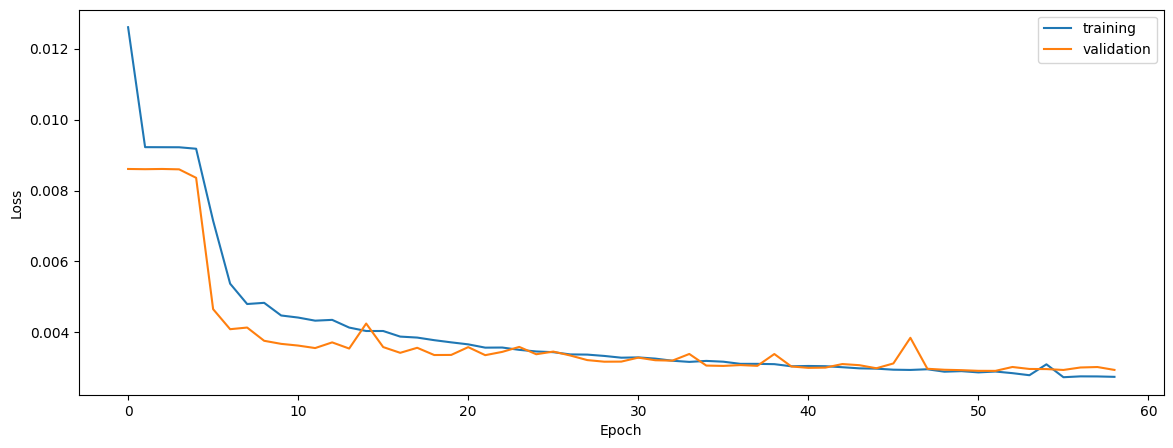

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


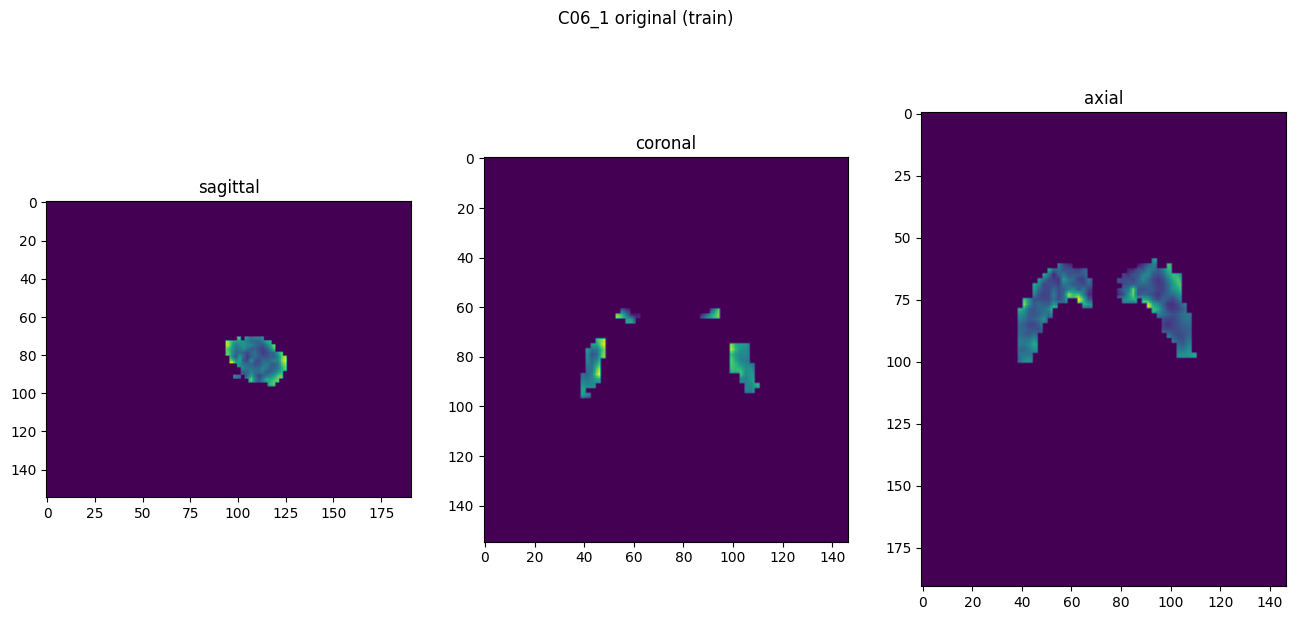

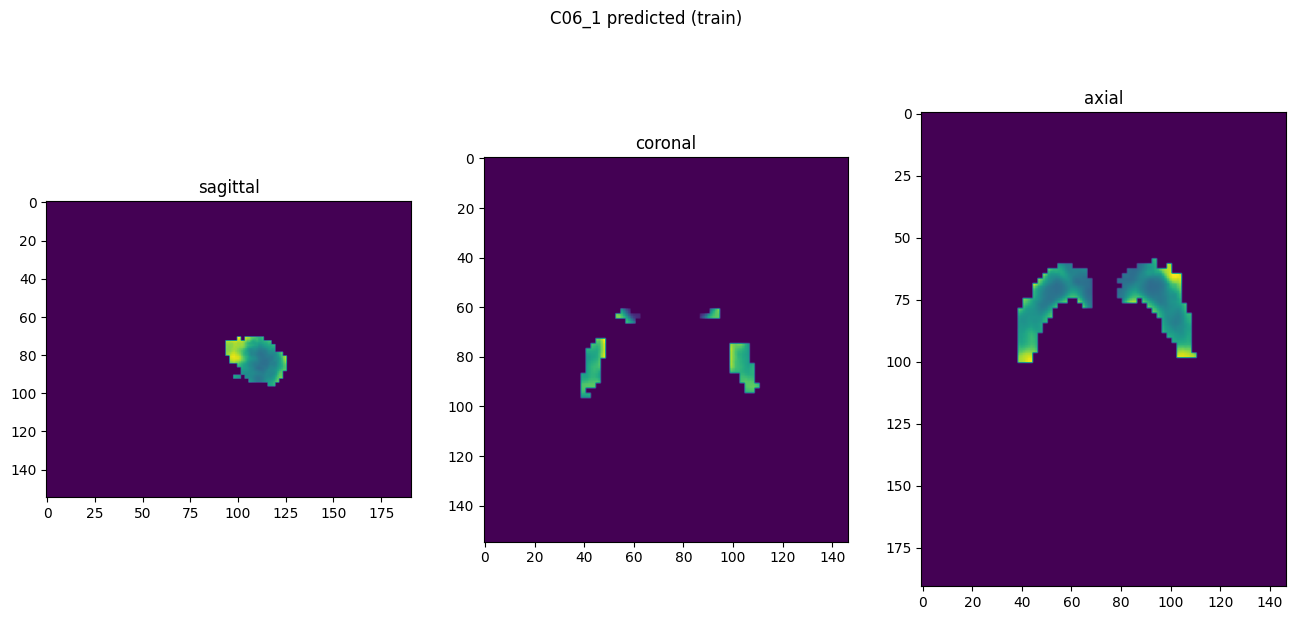

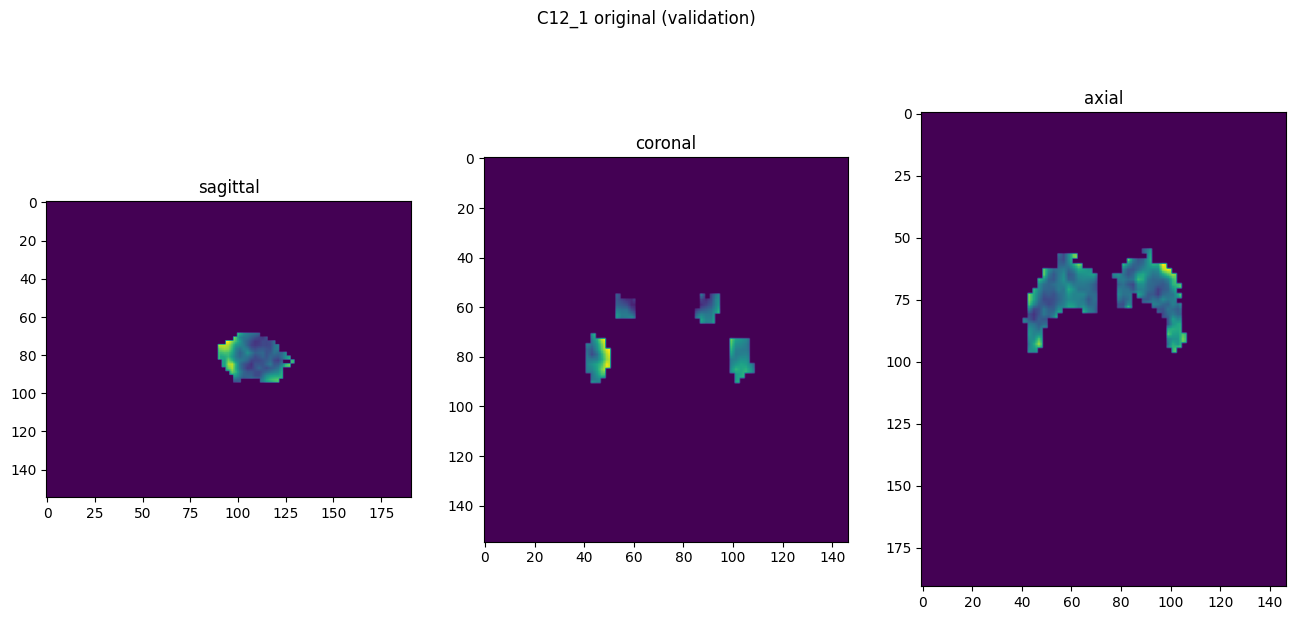

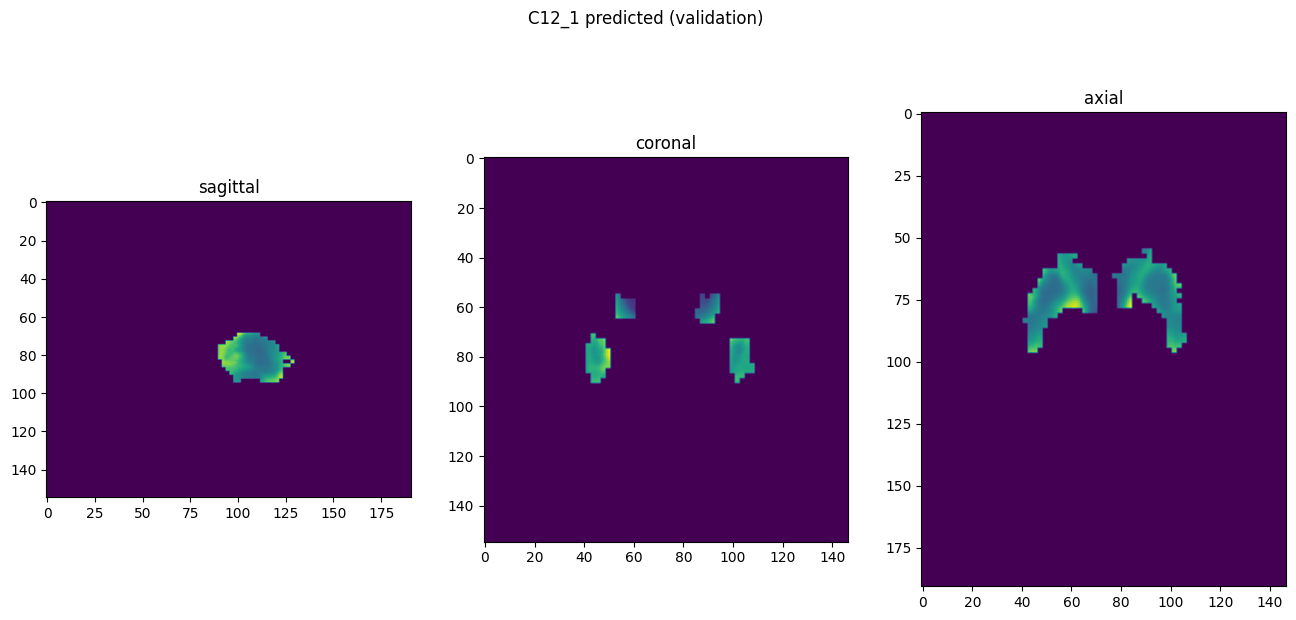

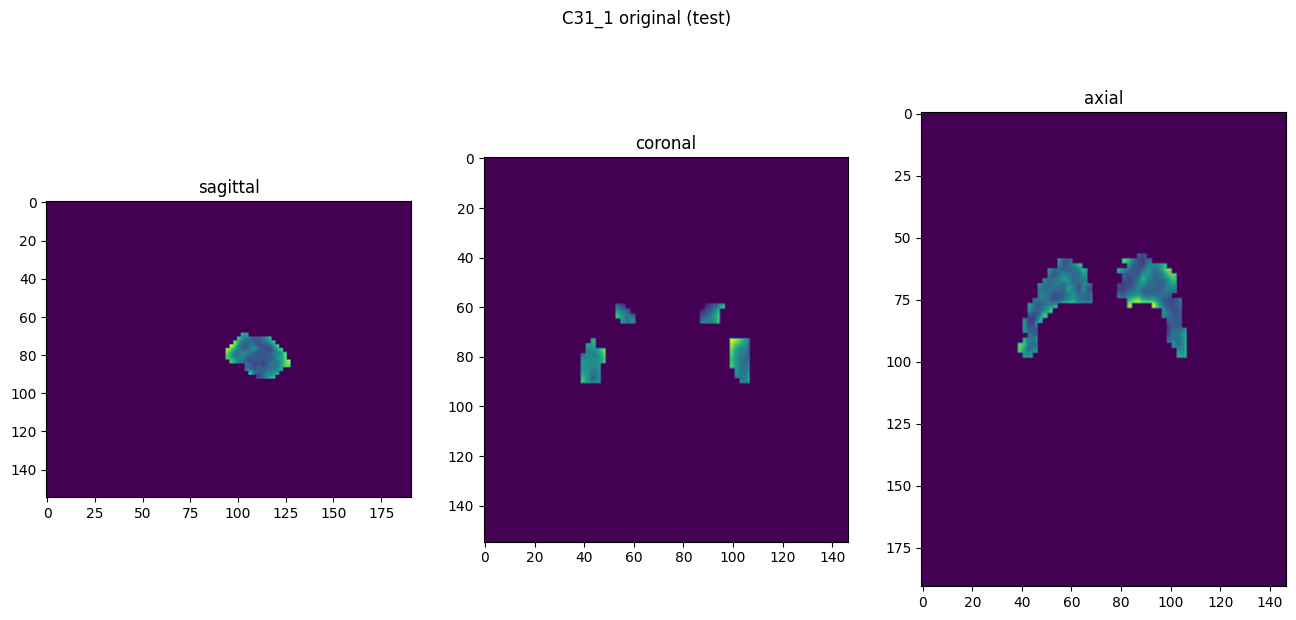

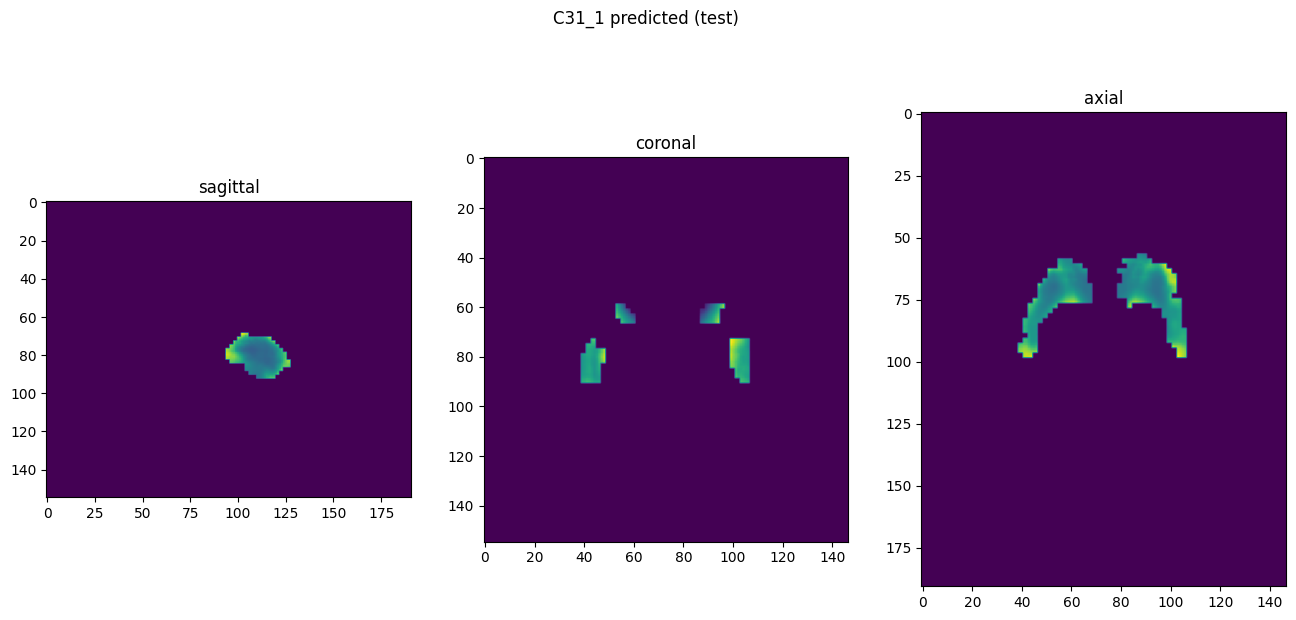

In [10]:
showResults(model, gen, threshold=None, background=False)